### __DETRで物体検出__

公式： https://huggingface.co/docs/transformers/v4.25.1/en/model_doc/detr


In [1]:
!pip install transformers timm | tail -n 1

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection

In [3]:
# 画像のダウンロード
!wget http://images.cocodataset.org/val2017/000000039769.jpg

--2022-12-26 00:43:55--  http://images.cocodataset.org/val2017/000000039769.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.169.49, 52.217.141.201, 52.217.193.113, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.169.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173131 (169K) [image/jpeg]
Saving to: ‘000000039769.jpg’

000000039769.jpg    100%[===================>] 169.07K   851KB/s    in 0.2s    

2022-12-26 00:43:55 (851 KB/s) - ‘000000039769.jpg’ saved [173131/173131]



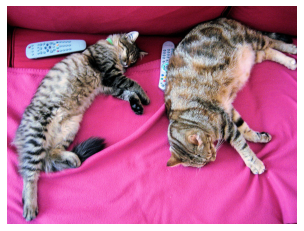

In [4]:
# 画像を表示
file_name = "000000039769.jpg"
image = Image.open(file_name)
plt.imshow(image)
plt.axis("off")
plt.show()

In [5]:
model_name = "facebook/detr-resnet-50"
processor = DetrImageProcessor.from_pretrained(model_name)
model = DetrForObjectDetection.from_pretrained(model_name)

# 前処理
inputs = processor(image, return_tensors="pt")

# 推論
outputs = model(**inputs)
outputs

Downloading:   0%|          | 0.00/274 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/detr/image_processing_detr.py:773: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


Downloading:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


DetrObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-19.1194,  -0.0893, -11.0154,  ...,  -8.7117,  -9.8543,  10.6531],
         [-17.3640,  -1.8035, -14.0219,  ...,  -8.2177,  -4.1631,  11.4021],
         [-20.0461,  -0.5837, -11.1060,  ...,  -9.2851, -12.1836,  11.1371],
         ...,
         [-19.7237,  -1.3058, -10.1437,  ..., -10.4849, -12.9238,  11.2945],
         [-12.8114,   1.9661,  -5.0197,  ...,  -6.7028,  -7.3127,   6.2644],
         [-17.3271,  -0.8608, -13.1640,  ...,  -6.6456,  -3.8822,  10.6797]]],
       grad_fn=<ViewBackward0>), pred_boxes=tensor([[[0.4433, 0.5302, 0.8853, 0.9056],
         [0.5494, 0.2517, 0.0529, 0.2015],
         [0.4998, 0.5360, 0.9956, 0.9024],
         [0.5534, 0.1835, 0.0415, 0.0616],
         [0.4998, 0.4116, 0.9948, 0.8237],
         [0.5957, 0.5033, 0.8091, 0.9647],
         [0.5416, 0.2791, 0.0393, 0.2099],
         [0.1607, 0.2160, 0.2274, 0.1434],
         [0.1738, 0.1822, 0.1956, 0.0785],
         [0.4997, 0.3887, 0.999

In [6]:
# PillowのsizeはW×Hを返すので、H×W(480×640)に変換
target_sizes = torch.tensor([image.size[::-1]])
id2label = model.config.id2label

# outputsをCOCO API形式で出力する後処理
results = processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
results = pd.DataFrame({
    "score": results["scores"].tolist(),
    "label": [id2label[id.item()] for id in results["labels"]],
    "x1": results["boxes"][:, 0].tolist(),
    "y1": results["boxes"][:, 1].tolist(),
    "x2": results["boxes"][:, 2].tolist(),
    "y2": results["boxes"][:, 3].tolist(),
})

results

,score,label,x1,y1,x2,y2
0,0.998220,remote,40.163311,70.811562,175.547104,117.984138
1,0.996002,remote,333.241730,72.550117,368.328796,187.663635
2,0.995474,couch,-0.022602,1.149631,639.727173,473.761078
3,0.998801,cat,13.240814,52.054680,314.018677,470.927368
4,0.998678,cat,345.401794,23.853779,640.371704,368.721710


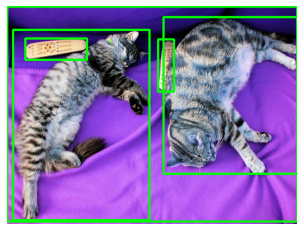

In [7]:
# 推論結果の表示
annot_image = cv2.imread(file_name)

for i in range(results.shape[0]):
    cv2.rectangle(
        annot_image,
        pt1=(round(results.loc[i, "x1"]), round(results.loc[i, "y1"])),
        pt2=(round(results.loc[i, "x2"]), round(results.loc[i, "y2"])),
        color=(0, 255, 0),
        thickness=3,
    )

plt.imshow(annot_image)
plt.axis("off")
plt.show()